Data Preprocessing/ EDA

1.   Understand data
2.   Data Distribution
3.   Creating Severity
3.   Correlation Analysis
4.   

In [72]:
from datetime import timedelta
import os

import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTENC
from sklearn.model_selection import train_test_split



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [55]:
# df include both NonAP and AP ICD diagnosis (ARE ALL NONAP JUST DONT HAVE AN ICD_CODE?)
## MAYBE WE CAN USE MOST CORRELATED ICD_CODE TEHRE TO FIND COMORBIDILITY
df = pd.read_csv('/content/AP_ICD_Lipase_Final_Dataset.csv')

In [15]:
df.head()

,subject_id,hadm_id,charttime,lipase_level,admittime,dischtime,gender,age,race,in_hospital_death,length_of_stay,icd_code,label
0,10004606,29242151,2159-02-20 18:30:00,1222.0,2159-02-20 13:43:00,2159-03-06 16:51:00,F,64,WHITE,False,14.130556,K8510,AP
1,10006431,24638489,2129-01-23 23:36:00,508.0,2129-01-24 01:08:00,2129-01-30 16:50:00,F,66,WHITE,False,6.654167,K8580,AP
2,10017531,22580355,2159-09-22 20:56:00,1164.0,2159-09-22 19:30:00,2159-10-24 13:40:00,M,63,WHITE,False,31.756944,5770,AP
3,10021357,25937617,2144-12-30 06:55:00,1249.0,2144-12-27 19:41:00,2145-01-04 19:54:00,F,91,WHITE,False,8.009028,5770,AP
4,10036086,28728587,2196-05-26 09:25:00,677.0,2196-05-20 02:47:00,2196-06-12 11:42:00,M,57,WHITE,False,23.371528,5770,AP


In [16]:
len(df)

2106

In [20]:
df.describe()

,subject_id,hadm_id,lipase_level,age,length_of_stay
count,2.106000e+03,2.106000e+03,2106.000000,2106.00000,2106.000000
mean,1.496009e+07,2.504919e+07,2597.290598,58.52849,11.705251
std,2.902143e+06,2.849314e+06,24193.389082,17.77819,15.434402
min,1.000461e+07,2.000264e+07,420.000000,18.00000,0.117361
25%,1.246589e+07,2.261443e+07,572.000000,46.00000,3.552257
50%,1.494135e+07,2.505391e+07,880.000000,59.00000,6.201042
75%,1.748184e+07,2.754032e+07,1653.250000,73.00000,13.990799
max,1.999888e+07,2.999193e+07,999999.000000,91.00000,219.908333


# Understanding Data

**CATEGORICAL: gender/ race/ in_hospital_death**

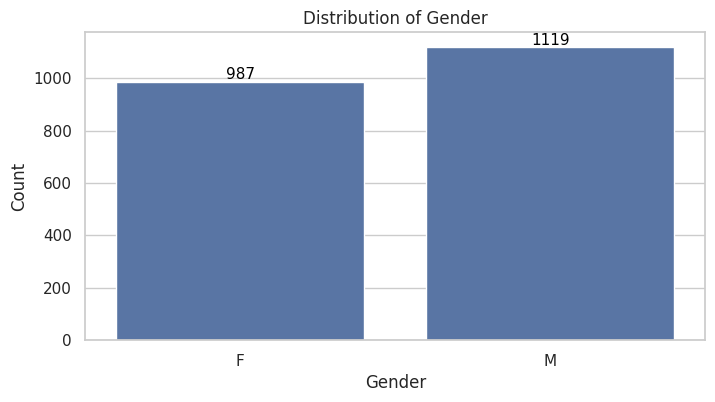

In [22]:
sns.set(style="whitegrid")

# Creating a count plot for gender
plt.figure(figsize=(8, 4))
ax = sns.countplot(x='gender', data=df)
plt.title('Distribution of Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=11, color='black', xytext=(0, 5), textcoords='offset points')
plt.show()


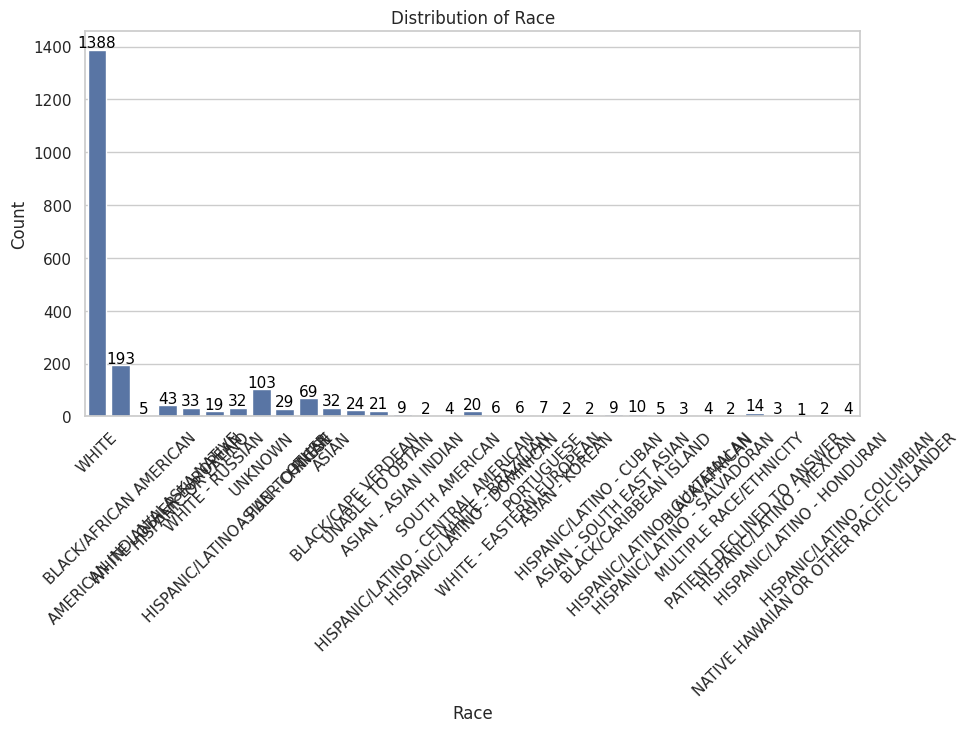

In [23]:
# Creating a count plot for race
plt.figure(figsize=(10, 5))
ax = sns.countplot(x='race', data=df)
plt.title('Distribution of Race')
plt.xlabel('Race')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Useful if there are many categories or long names
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=11, color='black', xytext=(0, 5), textcoords='offset points')
plt.show()

## very biased towards race WHITE
## Were all patients associated with one race?

In [27]:
len(df[df['race'] == "WHITE"])

1388

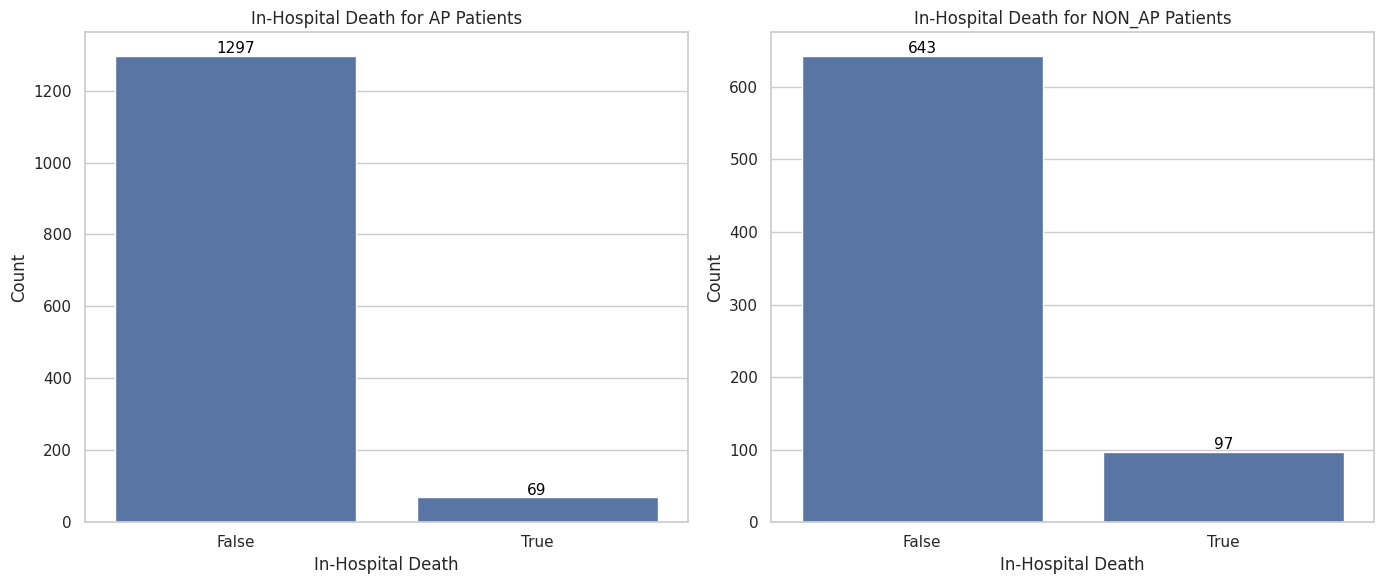

In [31]:
sns.set(style="whitegrid")
plt.figure(figsize=(14, 6))

# First plot: Distribution of in-hospital death for patients with AP
plt.subplot(1, 2, 1)
ax1 = sns.countplot(x='in_hospital_death', data=df[df['label'] == 'AP'])
plt.title('In-Hospital Death for AP Patients')
plt.xlabel('In-Hospital Death')
plt.ylabel('Count')
# Annotate bars
for p in ax1.patches:
    ax1.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=11, color='black', xytext=(0, 5), textcoords='offset points')

# Second plot: Distribution of in-hospital death for patients with NOT_AP
plt.subplot(1, 2, 2)
ax2 = sns.countplot(x='in_hospital_death', data=df[df['label'] == 'NON-AP'])
plt.title('In-Hospital Death for NON_AP Patients')
plt.xlabel('In-Hospital Death')
plt.ylabel('Count')
# Annotate bars
for p in ax2.patches:
    ax2.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=11, color='black', xytext=(0, 5), textcoords='offset points')

# Show the plots
plt.tight_layout()
plt.show()


**NUMERICAL**
1. length of stay
2. length of stay for AP in_hosp_death or not_death
3. level of lipase

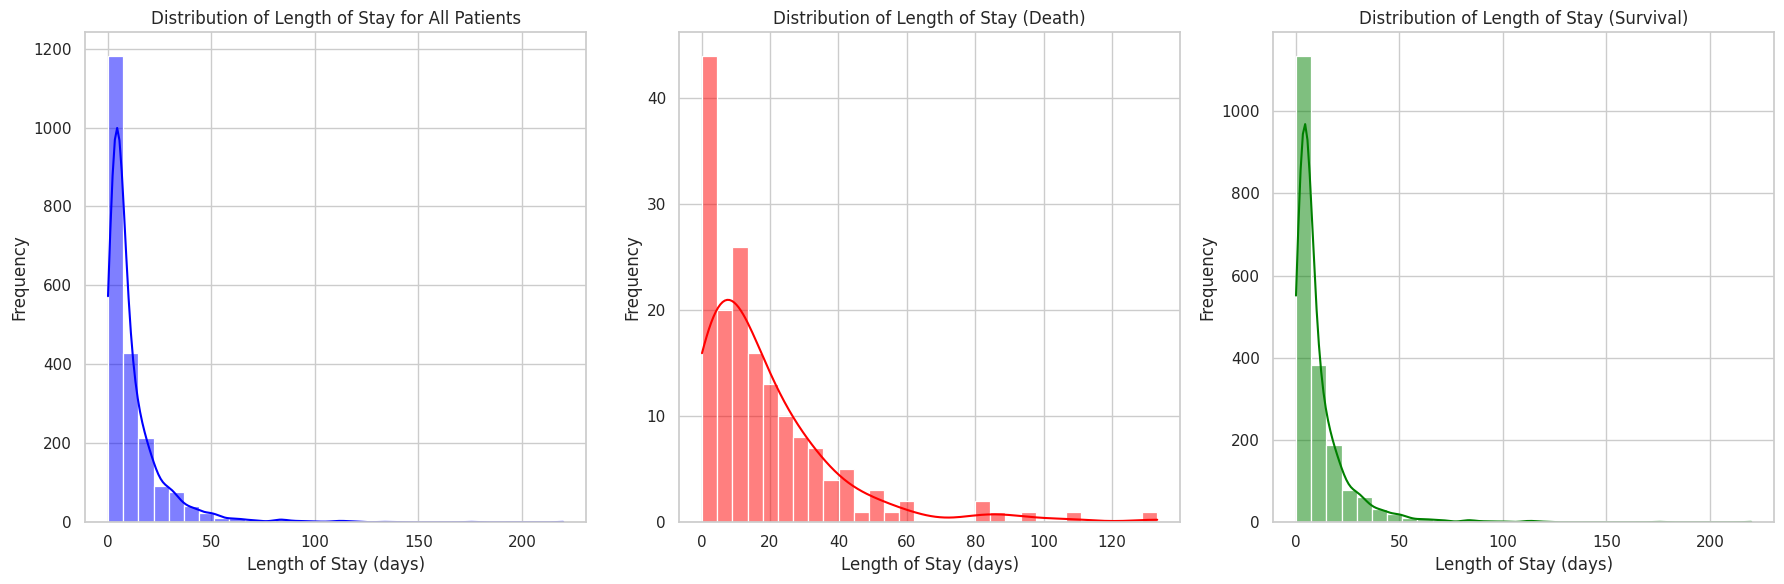

In [33]:
plt.figure(figsize=(18, 6))

# Histogram for the entire dataset
plt.subplot(1, 3, 1)
sns.histplot(df['length_of_stay'], bins=30, kde=True, color='blue')
plt.title('Distribution of Length of Stay for All Patients')
plt.xlabel('Length of Stay (days)')
plt.ylabel('Frequency')

# Histogram for patients where in_hospital_death is True
plt.subplot(1, 3, 2)
sns.histplot(df[df['in_hospital_death'] == True]['length_of_stay'], bins=30, kde=True, color='red')
plt.title('Distribution of Length of Stay (Death)')
plt.xlabel('Length of Stay (days)')
plt.ylabel('Frequency')

# Histogram for patients where in_hospital_death is False
plt.subplot(1, 3, 3)
sns.histplot(df[df['in_hospital_death'] == False]['length_of_stay'], bins=30, kde=True, color='green')
plt.title('Distribution of Length of Stay (Survival)')
plt.xlabel('Length of Stay (days)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()



1. Short Stays Predominate: In all groups, there's a clear concentration of cases with short hospital stays. This is typical in many healthcare settings where the goal is to minimize hospital stay without compromising patient care.
2. Differences in Length of Stay Distribution: The fact that deceased patients generally have shorter stays could be indicative of severe cases that unfortunately result in rapid deterioration, or it could reflect terminal cases admitted for end-of-life care.
3. Survivors with Extended Stays: The heavier tail in the survivors' histogram suggests some patients might have longer recovery periods, possibly due to complications, more extensive treatments, or slower recovery processes.

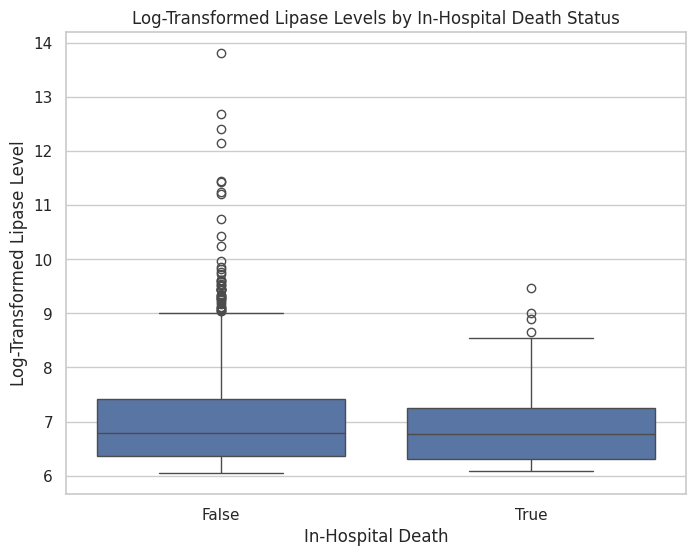

In [46]:
import numpy as np

plt.figure(figsize=(8, 6))
# Apply a log transformation to the lipase levels
sns.boxplot(x='in_hospital_death', y=np.log1p(df['lipase_level']), data=df)  # log1p is used to handle zero values
plt.title('Log-Transformed Lipase Levels by In-Hospital Death Status')
plt.xlabel('In-Hospital Death')
plt.ylabel('Log-Transformed Lipase Level')
plt.show()



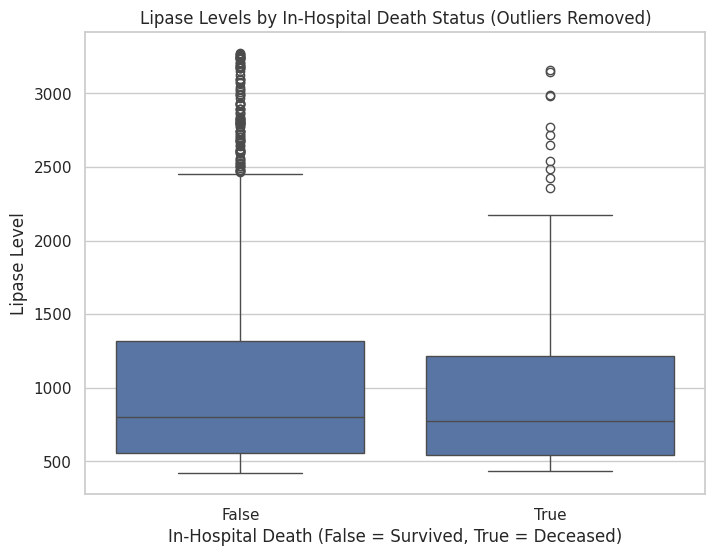

In [47]:
# Calculate IQR
Q1 = df['lipase_level'].quantile(0.25)
Q3 = df['lipase_level'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds to identify outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter data to exclude outliers
filtered_df = df[(df['lipase_level'] > lower_bound) & (df['lipase_level'] < upper_bound)]

# Plotting without outliers
plt.figure(figsize=(8, 6))
sns.boxplot(x='in_hospital_death', y='lipase_level', data=filtered_df)
plt.title('Lipase Levels by In-Hospital Death Status (Outliers Removed)')
plt.xlabel('In-Hospital Death (False = Survived, True = Deceased)')
plt.ylabel('Lipase Level')
plt.show()

In [48]:
from scipy.stats import mannwhitneyu

# Filter the data for the two groups
group_dead = df[df['in_hospital_death'] == 1]['length_of_stay']
group_survived = df[df['in_hospital_death'] == 0]['length_of_stay']

# Perform the Mann-Whitney U Test
stat, p = mannwhitneyu(group_dead, group_survived)

print(f'Statistics={stat}, p-value={p}')
if p < 0.05:
    print("The difference in length of stay between groups is statistically significant.")
else:
    print("No significant difference in length of stay between groups.")

Statistics=196733.5, p-value=2.0411985524990874e-06
The difference in length of stay between groups is statistically significant.


# Creating Severity

In [61]:
import pandas as pd

def categorize_severity(df):
    deceased_df = df[df['in_hospital_death'] == True]
    deceased_df['severity'] = 'death'

    # Remove deceased patients from the main DataFrame
    non_deceased_df = df[df['in_hospital_death'] == False]

    # Define the bins and labels for severity
    bins = [0, 1.5, 6.9, 14.2, float('inf')]
    labels = ['mild', 'moderate', 'severe', 'critical']


    non_deceased_df['severity'] = pd.cut(non_deceased_df['length_of_stay'], bins=bins, labels=labels, right=False)
    final_df = pd.concat([non_deceased_df, deceased_df], ignore_index=True)

    return final_df


In [62]:
final_df = categorize_severity(df)

<ipython-input-61-f8448b0be46c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  deceased_df['severity'] = 'death'
<ipython-input-61-f8448b0be46c>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_deceased_df['severity'] = pd.cut(non_deceased_df['length_of_stay'], bins=bins, labels=labels, right=False)


In [63]:
final_df

,subject_id,hadm_id,charttime,lipase_level,admittime,dischtime,gender,age,race,in_hospital_death,length_of_stay,icd_code,label,severity
0,10004606,29242151,2159-02-20 18:30:00,1222.0,2159-02-20 13:43:00,2159-03-06 16:51:00,F,64,WHITE,False,14.130556,K8510,AP,severe
1,10006431,24638489,2129-01-23 23:36:00,508.0,2129-01-24 01:08:00,2129-01-30 16:50:00,F,66,WHITE,False,6.654167,K8580,AP,moderate
2,10017531,22580355,2159-09-22 20:56:00,1164.0,2159-09-22 19:30:00,2159-10-24 13:40:00,M,63,WHITE,False,31.756944,5770,AP,critical
3,10021357,25937617,2144-12-30 06:55:00,1249.0,2144-12-27 19:41:00,2145-01-04 19:54:00,F,91,WHITE,False,8.009028,5770,AP,severe
4,10036086,28728587,2196-05-26 09:25:00,677.0,2196-05-20 02:47:00,2196-06-12 11:42:00,M,57,WHITE,False,23.371528,5770,AP,critical
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2101,19403862,29106273,2130-07-29 19:59:00,462.0,2130-07-27 22:37:00,2130-08-01 23:03:00,F,86,WHITE,True,5.018056,NaN,NON-AP,death
2102,19502669,26211447,2117-01-25 08:14:00,628.0,2117-01-15 21:43:00,2117-01-25 08:40:00,M,48,WHITE,True,9.456250,NaN,NON-AP,death
2103,19651093,26488509,2192-03-19 15:00:00,546.0,2192-03-17 21:05:00,2192-07-03 19:08:00,M,74,WHITE,True,107.918750,NaN,NON-AP,death
2104,19669999,28614555,2148-08-09 23:40:00,2066.0,2148-08-10 02:24:00,2148-08-10 13:55:00,F,84,OTHER,True,0.479861,NaN,NON-AP,death


<ipython-input-65-a8ad15ae833a>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='severity', data=df, order=['mild', 'moderate', 'severe', 'critical', 'death'], palette='viridis')


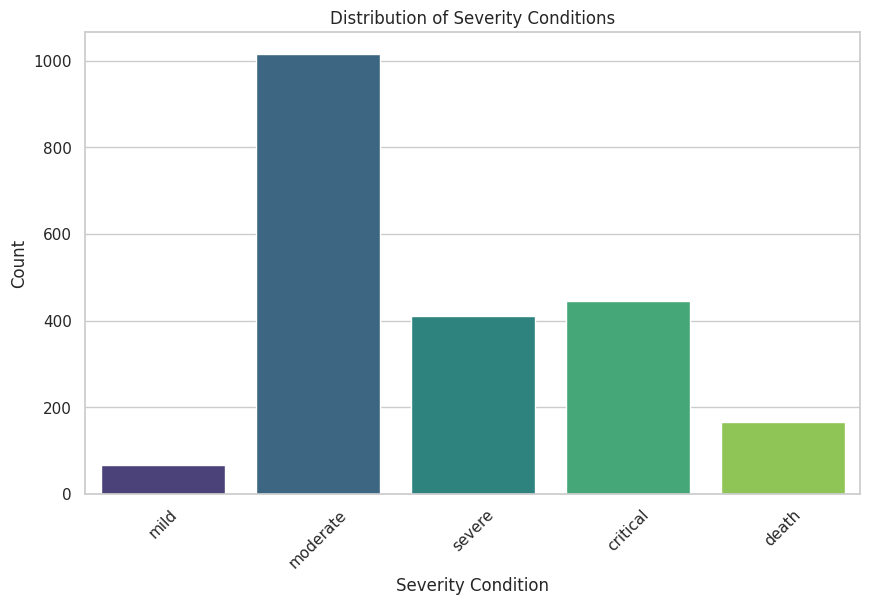

In [65]:
def plot_severity_distribution(df):
    plt.figure(figsize=(10, 6))
    sns.countplot(x='severity', data=df, order=['mild', 'moderate', 'severe', 'critical', 'death'], palette='viridis')
    plt.title('Distribution of Severity Conditions')
    plt.xlabel('Severity Condition')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()

# Assuming 'df_with_severity' is your DataFrame after applying the 'categorize_severity' function
plot_severity_distribution(final_df)


In [71]:
final_df.groupby('severity')['lipase_level'].describe()

,count,mean,std,min,25%,50%,75%,max
severity,,,,,,,,
critical,446.0,4135.304933,48352.078137,420.0,529.00,704.5,1275.00,999999.0
death,166.0,1366.825301,1540.088710,434.0,551.75,868.0,1405.00,12910.0
mild,67.0,1332.119403,1789.469191,437.0,539.50,736.0,1475.00,13595.0
moderate,1016.0,1950.908465,3643.785558,420.0,614.75,979.5,1959.75,76700.0
severe,411.0,3229.391727,20697.678071,421.0,579.00,872.0,1591.00,322000.0


# Handling Data Imabalance

In [75]:
columns_to_model = ['gender', 'age', 'lipase_level','severity']
model_df = final_df[columns_to_model]

In [77]:
X = model_df.drop('severity', axis=1)  # all other features
y = model_df['severity']  # severity condition


In [87]:
def apply_smotenc(df, target_name, categorical_features):
    categorical_feature_indices = [df.columns.get_loc(c) for c in categorical_features if c in df.columns]

    # Split the data into features and target
    X = df.drop(target_name, axis=1)
    y = df[target_name]

    # Splitting the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # SMOTENC
    smote_nc = SMOTENC(categorical_features=categorical_feature_indices, random_state=42)

    # Resample the dataset
    X_train_resampled, y_train_resampled = smote_nc.fit_resample(X_train, y_train)

    return X_train_resampled, y_train_resampled, X_test, y_test


In [88]:
X_train_resampled, y_train_resampled, X_test, y_test = apply_smotenc(model_df, 'severity', ['gender'])


In [89]:
# Output the shapes of the datasets to verify balance
print(f'Trained Resampled Features Shape: {X_train_resampled.shape}')
print(f'Trained Resampled Target Shape: {y_train_resampled.shape}')
print(f'Test Features Shape: {X_test.shape}')
print(f'Test Target Shape: {y_test.shape}')

Trained Resampled Features Shape: (3590, 3)
Trained Resampled Target Shape: (3590,)
Test Features Shape: (632, 3)
Test Target Shape: (632,)


In [100]:
y_train_resampled.value_counts()

,count
severity,
moderate,718
severe,718
death,718
critical,718
mild,718


In [101]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# One-hot encode categorical features in both the training and test sets
X_train_encoded = pd.get_dummies(X_train_resampled, drop_first=True)
X_test_encoded = pd.get_dummies(X_test, drop_first=True)

# Align columns in case get_dummies creates different columns in train/test
X_test_encoded = X_test_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)

# Create and train the random forest classifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train_encoded, y_train_resampled)

# Predict on the test set and evaluate the model
y_pred = model.predict(X_test_encoded)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

    critical       0.28      0.28      0.28       128
       death       0.19      0.34      0.24        56
        mild       0.02      0.10      0.04        20
    moderate       0.53      0.36      0.43       298
      severe       0.21      0.19      0.20       130

    accuracy                           0.30       632
   macro avg       0.25      0.26      0.24       632
weighted avg       0.37      0.30      0.32       632

